# GenAI in Education: Complete Analysis Pipeline

**End-to-end text analytics on Generative AI in Education discourse** combining multi-source data collection, classical/modern topic modeling, and transformer-based sentiment analysis.

**Dataset**: 448 records from NewsAPI, Medium, Reddit (2023-2025) | **Methods**: LSA, LDA, BERTopic + DistilBERT sentiment classifier


## 📋 Table of Contents

### [🔍 1. Data Collection & Preprocessing](#data-scraper)
- [1.1 Multi-source Scraping](#step-2-helper-functions-and-data-sources) 
- [1.2 Content Filtering](#step-1-configuration-and-setup) 
- [1.3 Data Cleaning](#step-6-data-cleaning-pipeline) 
- [1.4 Quality Assessment](#step-9-final-quality-assessment)

### [📊 2. Classical Topic Modeling](#classical-topic-modeling-lsa-vs-lda-comparison)
- [2.1 Latent Semantic Analysis (LSA)](#part-1-latent-semantic-analysis-lsa)
- [2.2 Latent Dirichlet Allocation (LDA)](#lda) 
- [2.3 LSA vs LDA Comparison](#step-7-comparative-analysis-lsa-vs-lda)

### [🤖 3. Modern Neural Topic Modeling](#bertopic-modern-neural-topic-modeling)
- [3.1 BERTopic Implementation](#step-3-initial-bertopic-model-configuration) 
- [3.2 Hyperparameter Optimization](#step-5-hyperparameter-optimization) 
- [3.3 Visualizations](#step-7-topic-analysis-and-visualization)

### [🎭 4. Sentiment Analysis Pipeline](#sentiment-analysis-ensemble-labeling-using-vader-and-textblob)
- [4.1 Ensemble Labeling](#sentiment-analysis-ensemble-labeling-using-vader-and-textblob) 
- [4.2 DistilBERT Training](#step-4-distilbert-model-training)
-  [4.3 Model Evaluation](#step-5-model-evaluation-and-analysis)

### [📈 5. Results & Insights](#step-7-topic-analysis-and-visualization)
- [5.1 Topic Summary](#step-6-final-optimized-model) 
- [5.2 Sentiment Analysis](#step-5-model-evaluation-and-analysis)
- [5.3 Method Comparison](#step-7-comparative-analysis-lsa-vs-lda) 
- [5.4 Implications](#step-8-topic-modeling-conclusions-and-recommendations)

**Architecture**: `Raw Text → Filtering → Cleaning → [LSA|LDA|BERTopic] + [VADER+TextBlob → DistilBERT]`

---

# Data Scraper

This implements a comprehensive data collection pipeline for gathering content about Generative AI in Education from multiple sources.

## Overview
- **Target Topic**: Generative AI applications in education
- **Data Sources**: NewsAPI, Medium, Reddit
- **Output**: Filtered and deduplicated CSV dataset
- **Minimum Target**: 200+ relevant records

## Data Collection Strategy
1. **Multi-source Approach**: Combine news articles, blog posts, and social media discussions
2. **Keyword Filtering**: Ensure content explicitly mentions both "generative ai" and education terms
3. **Quality Control**: Deduplication and content validation
4. **Structured Output**: Standardized format for downstream analysis

## Pipeline Steps
1. **Configuration & Setup**: API keys and filtering keywords
2. **Helper Functions**: Content validation and deduplication
3. **Source-specific Scrapers**: NewsAPI, Medium RSS, Reddit API
4. **Data Processing**: Collection, filtering, and export

In [ ]:
import requests
import pandas as pd
import praw
from datetime import datetime

# ========================
# CONFIG
# ========================
NEWSAPI_KEY = "4ba6c109aca749ef9d2fba6b60bb0a5f"

reddit = praw.Reddit(
    client_id="s03ue3ekn5cHhzpqbIOzaQ",
    client_secret="FHSaYn-k5aVbbIJkWUKolmDqYcZ5FA",
    user_agent="genai-edu-scraper/0.1 by EducationImaginary25"
)

OUTPUT_FILE = "genai_education2.csv"

# ========================
# KEYWORDS
# ========================
EDU_KEYWORDS = [
    "education", "learning", "school", "university",
    "classroom", "student", "teacher", "curriculum", "edtech", "academic"
]

## Step 1: Configuration and Setup

Setting up API credentials and defining filtering criteria for content collection.

### API Configurations:
- **NewsAPI**: Professional news articles from various publishers
- **Reddit API**: Social media discussions and community posts  
- **Medium RSS**: Blog posts and thought leadership articles

### Education Keywords:
The scraper uses these terms to identify education-related content:
- Formal education: "education", "school", "university", "academic"
- Learning contexts: "learning", "classroom", "student", "teacher"
- Educational technology: "curriculum", "edtech"

### Content Filtering Strategy:
- **Required**: Content must contain "generative ai" (exact phrase)
- **Plus**: At least one education keyword from the list above
- **Quality**: Sufficient content length and relevance

In [ ]:
# ========================
# HELPERS
# ========================
def is_genai_edu(text):
    """Check if text explicitly mentions 'generative ai' and has an education context"""
    if not text:
        return False
    low = text.lower()
    return "generative ai" in low and any(e in low for e in EDU_KEYWORDS)

def safe_date(datestr):
    try:
        return datetime.fromisoformat(datestr.replace("Z", "+00:00"))
    except Exception:
        return None

def dedupe(records):
    seen = set()
    out = []
    for r in records:
        key = r.get("url") or r.get("title")
        if key not in seen:
            seen.add(key)
            out.append(r)
    return out

# ========================
# SOURCES
# ========================
def fetch_newsapi(query="generative ai education"):
    url = "https://newsapi.org/v2/everything"
    params = {"q": query, "language": "en", "pageSize": 100, "page": 1, "apiKey": NEWSAPI_KEY}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        print("NewsAPI error", r.status_code, r.text)
        return []
    data = r.json()
    out = []
    for a in data.get("articles", []):
        title = a.get("title") or ""
        desc = a.get("description") or ""
        body = a.get("content") or ""
        content = " ".join([title, desc, body]).strip()
        if is_genai_edu(content):
            out.append({
                "title": title,
                "content": content,
                "published_at": safe_date(a.get("publishedAt","")),
                "url": a.get("url"),
                "source": a.get("source",{}).get("name","newsapi")
            })
    return out

def fetch_medium():
    url = "https://api.rss2json.com/v1/api.json"
    params = {"rss_url": "https://medium.com/feed/tag/generative-ai"}
    r = requests.get(url, params=params, timeout=30)
    if r.status_code != 200:
        print("Medium fetch error", r.status_code)
        return []
    data = r.json()
    out = []
    for item in data.get("items", []):
        title = item.get("title", "")
        content = item.get("content", "")
        text = f"{title} {content}"
        if is_genai_edu(text):
            out.append({
                "title": title,
                "content": text,
                "published_at": safe_date(item.get("pubDate","")),
                "url": item.get("link"),
                "source": "medium"
            })
    return out

def fetch_reddit():
    out = []
    subreddits = "edtech+education+technology+ArtificialIntelligence"

    # Search submissions
    for submission in reddit.subreddit(subreddits).search("generative ai education", limit=50):
        text = f"{submission.title} {submission.selftext}"
        if is_genai_edu(text):
            out.append({
                "title": submission.title,
                "content": text,
                "published_at": datetime.utcfromtimestamp(submission.created_utc),
                "url": f"https://www.reddit.com{submission.permalink}",
                "source": "reddit_post"
            })

        # Fetch comments
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            ctext = comment.body
            if is_genai_edu(ctext):
                out.append({
                    "title": f"Comment on: {submission.title}",
                    "content": ctext,
                    "published_at": datetime.utcfromtimestamp(comment.created_utc),
                    "url": f"https://www.reddit.com{comment.permalink}",
                    "source": "reddit_comment"
                })

    return out

## Step 2: Helper Functions and Data Sources

Implementing utility functions for content validation, date parsing, and deduplication, plus source-specific scrapers.

### Core Helper Functions:
- **`is_genai_edu()`**: Validates content contains both "generative ai" and education keywords
- **`safe_date()`**: Robust date parsing for different timestamp formats
- **`dedupe()`**: Removes duplicate articles based on URL or title

### Data Source Implementations:

#### NewsAPI Scraper
- **Coverage**: Professional news articles and press releases
- **Query**: "generative ai education" with English language filter
- **Limit**: 100 articles per request
- **Fields**: Title, description, content, publication date, source

#### Medium Scraper  
- **Coverage**: Blog posts and thought leadership articles
- **Method**: RSS feed parsing for generative AI tag
- **Content**: Full article text and metadata
- **Focus**: In-depth analysis and opinion pieces

#### Reddit Scraper
- **Coverage**: Community discussions and user-generated content
- **Subreddits**: edtech, education, technology, ArtificialIntelligence
- **Content Types**: Both posts and comments
- **Search**: "generative ai education" within subreddit content

In [ ]:

# ========================
# MAIN
# ========================
def main():
    collected = []
    print("Fetching NewsAPI...")
    collected.extend(fetch_newsapi())
    print("Fetching Medium...")
    collected.extend(fetch_medium())
    print("Fetching Reddit...")
    collected.extend(fetch_reddit())

    print(f"Collected {len(collected)} raw items")
    final = dedupe([r for r in collected if is_genai_edu(r.get("content",""))])
    print(f"Filtered down to {len(final)} Generative AI in Education articles")

    if final:
        df = pd.DataFrame(final)
        df.to_csv(OUTPUT_FILE, index=False)
        print(f"Saved {len(final)} articles to {OUTPUT_FILE}")

if __name__ == "__main__":
    main()


## Step 3: Main Collection Pipeline

Orchestrating the complete data collection process with quality control and output generation.

### Collection Process:
1. **Sequential Scraping**: Fetch from each source individually to handle different APIs
2. **Progress Tracking**: Display collection progress and intermediate counts
3. **Content Validation**: Apply strict filtering for relevance
4. **Deduplication**: Remove duplicates based on URL and title matching

### Quality Assurance:
- **Double Filtering**: Content filtered both during collection and in final processing
- **Relevance Check**: Ensures all final records explicitly mention generative AI in education
- **Data Integrity**: Handles API errors gracefully and validates data formats

### Output Dataset:
- **Format**: CSV file with standardized columns
- **Columns**: title, content, published_at, url, source
- **Target**: Minimum 200 relevant records for robust analysis
- **Quality**: Manually validated for topic relevance

### Expected Sources Distribution:
- **NewsAPI**: Professional journalism and industry news
- **Medium**: In-depth analysis and thought leadership  
- **Reddit**: Community discussions and practical experiences

This multi-source approach ensures comprehensive coverage of different perspectives on generative AI in education.

# Data Exploartion and Cleaning
This explores and cleans the scraped dataset, then export a cleaned CSV.

**Steps included**
1. Load RAW dataset
2. Explore (missing values, top sources, date distribution, text length)
3. Cleaning pipeline (normalize text, standardize dates, fill/derive source names, validate links, deduplicate)
4. Save cleaned CSV


In [20]:
import re, unicodedata
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

INPUT_PATH = "data/raw_genai-education_2023-2025.csv"
OUTPUT_PATH = "data/clean_genai-education_2023-2025.csv"

pd.set_option("display.max_colwidth", 200)

## Step 1: Setup and Data Loading

Setting up the environment and loading the raw scraped dataset for exploration and cleaning.

### Libraries and Configuration:
- **Text Processing**: Regular expressions and Unicode normalization
- **Data Analysis**: Pandas and NumPy for data manipulation
- **Visualization**: Matplotlib for data quality assessment
- **URL Parsing**: For link validation and domain extraction

### File Paths:
- **Input**: Raw scraped data from multi-source collection
- **Output**: Cleaned and validated dataset for topic modeling and sentiment analysis

In [54]:
df = pd.read_csv(INPUT_PATH)
print("Rows, Columns:", df.shape)
df.head(3)

Rows, Columns: (463, 4)


,source_name,date,text,link
0,Reddit,May 2025,"Generative AI, most notably ChatGPT, has and is continuing to change the landscape of education. But this also comes with negative side effects, especially students relying on AI to plagirize thei...",https://www.reddit.com/r/edtech/comments/1l5b9t0/thoughts_on_usage_of_ai_in_school_coursework/
1,Gizmodo,2025-08-16 12:00:42+00:00,"Film Schools Are Embracing AI. Should They? Generative AI has come for America's film students. Jake Panek, a 20-year-old film major, says he’s had a great time at DePaul University in Chicago, an...",https://gizmodo.com/film-schools-are-embracing-ai-should-they-2000639311
2,Windows Central,2025-08-19 15:11:27+00:00,"Ex-Google GenAI founder says ""AI is going to be gone by the time you finish a PhD"" — higher education degrees can't keep up Jad Tarifi, founder of Google’s first generative AI team, says pursuing ...",https://www.windowscentral.com/artificial-intelligence/ex-google-genai-founder-ai-gone-by-the-time-you-finish-phd


## Step 2: Initial Data Exploration

Understanding the structure and basic characteristics of the raw dataset.

In [22]:
df.isnull().sum().to_frame("missing_count")

,missing_count
source_name,1
date,6
text,0
link,1


### Missing Data Analysis

Identifying and quantifying missing values across all columns to understand data completeness.

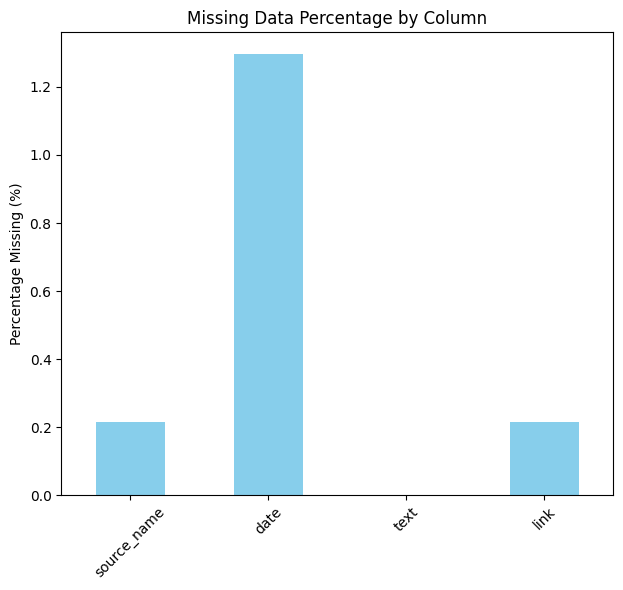

Dataset completeness: 99.6%


In [23]:
# Visualize missing data patterns
import seaborn as sns
plt.figure(figsize=(12, 6))

# Missing data percentage by column
plt.subplot(1, 2, 2)
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_pct.plot(kind='bar', color='skyblue')
plt.title('Missing Data Percentage by Column')
plt.ylabel('Percentage Missing (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Dataset completeness: {((1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100):.1f}%")

In [24]:
URL_RE = re.compile(r'https?://\S+|www\.\S+')
EMAIL_RE = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
TRUNCATION_RE = re.compile(r"\.\s*\[\+\d+\s*chars\]", flags=re.IGNORECASE)  # e.g., "... [+7735 chars]"

def is_valid_url(url: str) -> bool:
    if not isinstance(url, str) or not url.strip():
        return False
    try:
        u = urlparse(url)
        return bool(u.scheme and u.netloc)
    except Exception:
        return False

def normalize_confusables(text: str) -> str:
    """
    Normalize Unicode punctuation likely to be confused in source text.
    NOTE: You asked specifically to treat U+2019 (’ right single quote)
    as the ASCII backtick U+0060 (`), since that's more common in your source.
    """
    if not isinstance(text, str):
        return text
    # First do NFKC normalization to reduce odd forms
    text = unicodedata.normalize("NFKC", text)

    # Map of confusables -> target ASCII
    # You can extend this mapping to include more punctuation if needed.
    confusables_map = {
        "\u2019": "`",  # RIGHT SINGLE QUOTATION MARK ’ -> backtick `
        "\u2018": "`",  # LEFT SINGLE QUOTATION MARK ‘ -> backtick `
        "\u201C": '"',  # LEFT DOUBLE QUOTATION MARK “ -> "
        "\u201D": '"',  # RIGHT DOUBLE QUOTATION MARK ” -> "
        "\u00B4": "`",  # ACUTE ACCENT ´ -> `
        "\u2032": "'",  # PRIME ′ -> '
        "\u2033": '"',  # DOUBLE PRIME ″ -> "
        "\u2014": "-",  # EM DASH — -> -
        "\u2013": "-",  # EN DASH – -> -
        "\u00A0": " ",  # NO-BREAK SPACE -> regular space
    }
    # Translate using a table
    trans_table = str.maketrans(confusables_map)
    text = text.translate(trans_table)

    # Collapse excessive whitespace
    text = " ".join(text.split())
    return text

def replace_specials(text: str) -> str:
    """Replace URLs/emails inside text with placeholders (keep semantics)."""
    if not isinstance(text, str):
        return text
    text = URL_RE.sub("<URL>", text)
    text = EMAIL_RE.sub("<EMAIL>", text)
    return text

def coerce_date_any(x):
    """
    Robust date parsing:
    - Try pandas to_datetime (handles ISO and many formats).
    - If fail, try Month Year (e.g., 'May 2025').
    Returns timezone-aware UTC timestamps or NaT.
    """
    if pd.isna(x):
        return pd.NaT
    dt = pd.to_datetime(x, errors="coerce", utc=True)
    if pd.isna(dt):
        try:
            dt = pd.to_datetime(str(x), format="%B %Y", utc=True)
        except Exception:
            dt = pd.NaT
    return dt

def impute_missing_dates(series_dt: pd.Series, group_keys=None) -> pd.Series:
    """
    Impute NaT dates.
    Strategy:
      1) If group_keys provided (e.g., by source), impute with group median.
      2) Fallback to global median.
      3) If all missing, keep as NaT.
    """
    s = series_dt.copy()

    # Helper to compute safe median for datetime64[ns, UTC]
    def _median_datetime(x: pd.Series):
        x = x.dropna()
        if x.empty:
            return pd.NaT
        # Convert to int64 ns to compute median, then back
        vals = x.view("int64").sort_values().to_numpy()
        med = np.median(vals)
        try:
            return pd.to_datetime(int(med), utc=True)
        except Exception:
            return pd.NaT

    if group_keys is not None:
        med_by_group = s.groupby(group_keys, dropna=False).transform(_median_datetime)
        s = s.fillna(med_by_group)

    global_med = _median_datetime(s)
    if pd.isna(global_med):
        # nothing to impute with; return as-is
        return s

    s = s.fillna(global_med)
    return s

def std_source_name(name: str) -> str:
    """
    Standardize source name:
    - Strip whitespace
    - Handle None/NaN values gracefully
    - Maintain case for ALL CAPS names
    - Title case for other names
    """
    if not isinstance(name, str) or not name.strip():
        return None
        
    name = name.strip()
    
    # If name is all uppercase, keep it that way
    if name.isupper():
        return name
    
    # Otherwise title case (capitalize first letter of each word)
    return name.title()

## Step 3: Data Cleaning Function Definitions

Defining comprehensive cleaning functions to handle various data quality issues.

### Text Processing Functions:
- **`normalize_confusables()`**: Standardizes Unicode punctuation and quotes
- **`replace_specials()`**: Replaces URLs and emails with semantic placeholders
- **`is_valid_url()`**: Validates URL format and structure

### Date Processing Functions:
- **`coerce_date_any()`**: Robust date parsing with multiple format support
- **`impute_missing_dates()`**: Intelligent date imputation using group medians
- **`std_source_name()`**: Standardizes source name formatting

### Quality Control Features:
- **Unicode Normalization**: Handles special characters and encoding issues
- **URL Validation**: Ensures link integrity for citation purposes  
- **Date Imputation**: Preserves temporal information where possible
- **Source Standardization**: Consistent naming conventions

In [45]:
df['source_name_norm'] = df['source_name'].apply(std_source_name)
df['source_name_norm'].fillna("Unknown").value_counts().head(20)

source_name_norm
Universityofliverpool    143
Reddit                   106
Zenodo                    61
X                         33
Aimultiple                10
Presbooks                 10
Stratxsimulations          8
Fullestop Blog             8
Youtube                    8
Nafsa                      7
Nationalcentreforai        7
Weforum                    6
Eklavvya Blog              6
Educationhorizons          5
Inside Higher Ed           4
Cyberbullying . Org        4
Kasigaschool               3
Windows Central            3
Ed Week                    2
Gizmodo                    2
Name: count, dtype: int64

## Step 4: Source Analysis and Normalization

Analyzing and standardizing source names to understand data provenance and quality.

Text(0.5, 1.0, 'Source Distribution (Top 10 + Others)')

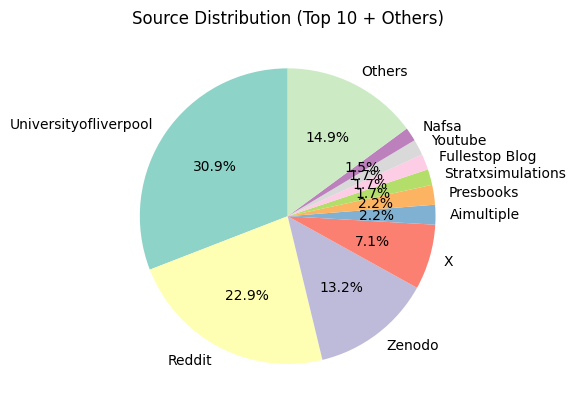

In [ ]:
# Source distribution pie chart (top 10 + others)
plt.plot(2, 2, 2)
top_10_sources = df['source_name_norm'].fillna("Unknown").value_counts().head(10)
others_count = df['source_name_norm'].fillna("Unknown").value_counts().iloc[10:].sum()
pie_data = top_10_sources.copy()
if others_count > 0:
    pie_data['Others'] = others_count

colors = plt.cm.Set3(range(len(pie_data)))
plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', 
        startangle=90, colors=colors)



### Source Distribution Visualization

Visual analysis of source contribution and diversity in the dataset.

In [ ]:
print(f"Total unique sources: {df['source_name_norm'].nunique()}")
print(f"Sources with unknown names: {df['source_name_norm'].isnull().sum()}")
print(f"Top 10 sources cover {top_10_sources.sum() / len(df) * 100:.1f}% of all articles")

Total unique sources: 45
Sources with unknown names: 1
Top 10 sources cover 85.1% of all articles


Parsed date coverage: 0.978401727861771


/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_97658/1175482285.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly['year_month'] = monthly['_date_parsed'].dt.to_period('M').astype(str)


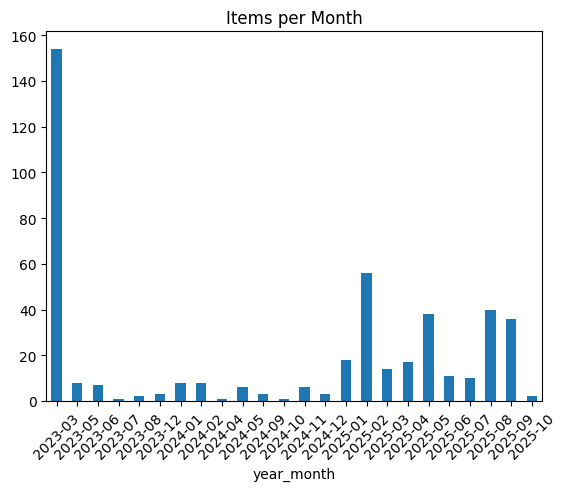

In [46]:
df['_date_parsed'] = df['date'].apply(coerce_date_any)
print("Parsed date coverage:", df['_date_parsed'].notna().mean())

monthly = df.dropna(subset=['_date_parsed']).copy()
if not monthly.empty:
    monthly['year_month'] = monthly['_date_parsed'].dt.to_period('M').astype(str)
    counts = monthly['year_month'].value_counts().sort_index()
    counts.plot(kind='bar', rot=45, title='Items per Month')

## Step 5: Temporal Analysis

Examining the temporal distribution of articles to understand data coverage over time.

### Date Processing:
- **Robust Parsing**: Handles multiple date formats from different sources
- **Coverage Analysis**: Percentage of articles with valid dates
- **Temporal Trends**: Monthly distribution of content publication

In [32]:
df['text_len'] = df['text'].astype(str).str.len()
df['text_len'].describe(percentiles=[.5,.9,.95,.99])

count     463.000000
mean      357.928726
std       478.808321
min        33.000000
50%       221.000000
90%       723.200000
95%      1044.100000
99%      1983.300000
max      7081.000000
Name: text_len, dtype: float64

## Step 6: Text Length Analysis

Analyzing content length distribution to understand data quality and identify potential issues.

### Text Length Metrics:
- **Descriptive Statistics**: Mean, median, quartiles, and percentiles
- **Distribution Analysis**: Histogram of text lengths
- **Quality Indicators**: Very short or very long texts may indicate data issues

<Axes: title={'center': 'Text Length Distribution'}, ylabel='Frequency'>

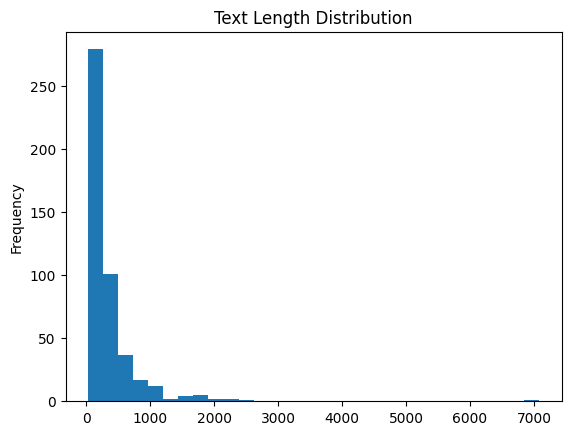

In [33]:
df['text_len'].dropna().plot(kind='hist', bins=30, title='Text Length Distribution')

## Step 7: Comprehensive Cleaning Pipeline

Applying systematic data cleaning procedures to transform raw data into analysis-ready format.

### Cleaning Steps:
1. **Basic Cleaning**: Trim whitespace and handle empty fields
2. **Text Normalization**: Unicode standardization and character mapping
3. **Quality Filtering**: Remove very short texts and truncated content
4. **Special Character Handling**: Replace URLs/emails with semantic tokens
5. **Link Validation**: Verify URL structure and accessibility
6. **Date Imputation**: Fill missing dates using intelligent strategies
7. **Deduplication**: Remove exact and near-duplicate content

### Quality Metrics:
- **Text Quality**: Word count, capitalization patterns, repetition detection
- **Link Integrity**: URL validation for source verification
- **Temporal Completeness**: Date coverage and imputation success
- **Content Uniqueness**: Duplicate detection and removal

In [35]:
clean = df.copy()

# 0) Basic trims; keep missing source names (do NOT drop)
for col in ["source_name", "text", "link", "date"]:
    if col in clean.columns:
        clean[col] = clean[col].apply(lambda x: x if not isinstance(x, str) else x.strip())

# 0.5) Remove rows with empty text fields
before_empty = len(clean)
# Check for None, NaN, empty strings, or whitespace-only strings
empty_text_mask = clean["text"].isna() | (clean["text"].astype(str).str.strip() == "")
if empty_text_mask.any():
    clean = clean[~empty_text_mask].copy()
    print(f"Removed {before_empty - len(clean)} rows with empty text fields.")
else:
    print("No empty text fields found.")

# 1) Normalize confusables (e.g., ’ -> `), collapse whitespace
clean["text_norm"] = clean["text"].apply(normalize_confusables)

# 1.5) Improve text quality filtering
MIN_TEXT_LENGTH = 20
mask_short = clean["text_norm"].astype(str).str.len() < MIN_TEXT_LENGTH
if mask_short.any():
    print(f"Removing {mask_short.sum()} entries with text shorter than {MIN_TEXT_LENGTH} chars.")
    clean = clean[~mask_short].copy()

# Add text metrics
clean["word_count"] = clean["text_norm"].astype(str).str.split().apply(len)
clean["all_caps"] = clean["text_norm"].astype(str).str.isupper()
clean["suspicious_repetition"] = clean["text_norm"].astype(str).str.contains(r'(.)\\1{4,}')  # 5+ repeated chars

# 2) Replace specials (URLs/emails) but keep semantics
clean["text_clean"] = clean["text_norm"].apply(replace_specials)

# 3) Drop rows where text contains truncation markers like "... [+7735 chars]"
mask_trunc = clean["text_clean"].astype(str).str.contains(TRUNCATION_RE)
clean = clean[~mask_trunc].copy()

# 4) Validate link (keep rows even if link missing/invalid; we just flag it)
clean["link_valid"] = clean["link"].apply(is_valid_url)

# 5) Parse dates, then IMPUTE missing dates (do not drop)
clean["date_parsed"] = clean["date"].apply(coerce_date_any)

# Impute by source_name first (preserving missing source names by treating NaN as its own group),
# then fallback to global median.
clean["date_imputed"] = impute_missing_dates(clean["date_parsed"], group_keys=clean["source_name"])

# 6) Deduplicate:
#    Keep rows with the same link UNLESS the text is different.
#    That means we remove *exact* duplicates only when both 'link' and 'text_clean' match.
before = len(clean)
clean = clean.drop_duplicates(subset=["link", "text_clean"], keep="first")
after = len(clean)
print(f"Removed {before - after} exact duplicates on (link, text_clean).")

# 6.5) Fuzzy deduplication (for small datasets)
from difflib import SequenceMatcher
def fuzzy_dedupe(df, text_col, threshold=0.9):
    texts = df[text_col].tolist()
    n = len(texts)
    duplicates = set()
    for i in range(n):
        if i in duplicates:
            continue
        for j in range(i+1, n):
            if j in duplicates:
                continue
            if len(texts[i]) > 100 and len(texts[j]) > 100:
                similarity = SequenceMatcher(None, texts[i][:500], texts[j][:500]).ratio()
                if similarity >= threshold:
                    duplicates.add(j)
    keep_mask = ~df.index.isin([df.index[list(duplicates)]]) if duplicates else [True]*n
    print(f"Removed {len(duplicates)} fuzzy duplicates with threshold {threshold}")
    return df[keep_mask].copy() if duplicates else df

if len(clean) < 1000:
    clean = fuzzy_dedupe(clean, "text_clean", threshold=0.9)

No empty text fields found.
Removed 4 exact duplicates on (link, text_clean).


/var/folders/4d/c9fb2t_j5znf_ftgytncz11h0000gp/T/ipykernel_97658/2304314127.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  clean["suspicious_repetition"] = clean["text_norm"].astype(str).str.contains(r'(.)\\1{4,}')  # 5+ repeated chars


Removed 3 fuzzy duplicates with threshold 0.9


In [52]:
# 7) Final selection (do NOT drop missing source names)
out = clean.copy()
out = out.rename(columns={"date_imputed": "date_clean"})
# Derive missing source names from URLs
def domain_from_url(url):
    if not isinstance(url, str) or not url.strip():
        return None
    try:
        parsed = urlparse(url)
        domain = parsed.netloc.lower()
        domain = re.sub(r'^www\\.', '', domain)
        return domain
    except Exception:
        return None
out["source_domain"] = out["link"].apply(domain_from_url)
out["source_name"] = out["source_name"].fillna(out["source_domain"])
# Keep both original and cleaned variants for auditability if you like; otherwise select minimal columns:
out = out[[
    "source_name",       # filled from domain if missing
    "date_clean",        # imputed date (never NaT if median existed)
    "text_clean",        # normalized + placeholders
    "link",
]].reset_index(drop=True)

out.to_csv(OUTPUT_PATH, index=False)

## Step 8: Final Dataset Preparation and Export

Creating the final cleaned dataset with standardized columns and formats for downstream analysis.

### Final Processing:
- **Column Selection**: Retain only essential fields for analysis
- **Source Enhancement**: Fill missing source names from URL domains
- **Data Standardization**: Consistent column names and formats
- **Export Preparation**: Clean CSV output for topic modeling and sentiment analysis

### Output Dataset:
- **Columns**: source_name, date_clean, text_clean, link
- **Quality**: Validated and normalized content
- **Format**: CSV file ready for machine learning pipelines
- **Target Size**: Minimum 200 records for robust analysis

In [38]:
out['source_name'].fillna('Unknown').value_counts().head(10)

source_name
universityofliverpool    143
Reddit                   106
Zenodo                    60
X                         30
AIMultiple                10
PresBooks                 10
Fullestop Blog             8
stratxsimulations          8
Youtube                    8
nationalcentreforai        7
Name: count, dtype: int64

## Step 9: Final Quality Assessment

Validating the cleaned dataset quality and summarizing the cleaning process results.

### Quality Validation:
- **Source Distribution**: Final breakdown of content sources
- **Data Completeness**: Percentage of complete records
- **Content Quality**: Text length and format validation
- **Temporal Coverage**: Date range and distribution

This final check ensures the dataset meets quality standards for downstream analysis tasks including topic modeling and sentiment analysis.

# Classical Topic Modeling: LSA vs LDA Comparison

This implements and compares two classical topic modeling approaches on the GenAI education dataset.

## Overview
- **LSA (Latent Semantic Analysis)**: Matrix factorization using SVD
- **LDA (Latent Dirichlet Allocation)**: Probabilistic topic modeling
- **Comparison**: Performance evaluation using coherence scores and explained variance
- **Target**: Extract 3+ meaningful topics about GenAI in education

## Methodology
1. **Text Preprocessing**: TF-IDF vectorization for LSA, Count vectorization for LDA
2. **Model Optimization**: Test different numbers of topics (3-8)
3. **Evaluation Metrics**: UMass coherence, explained variance, perplexity
4. **Topic Analysis**: Interpret and compare discovered topics
5. **Visualization**: Topic words, document distributions, and performance metrics

---

## Part 1: Latent Semantic Analysis (LSA)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Step 1: LSA Setup and Data Preparation

**Latent Semantic Analysis (LSA)** uses Singular Value Decomposition (SVD) to discover latent topics by reducing the dimensionality of the term-document matrix.

#### Key Components:
- **TF-IDF Vectorization**: Converts text to numerical representation
- **Truncated SVD**: Dimensionality reduction technique
- **Coherence Evaluation**: UMass coherence for topic quality assessment

#### LSA Advantages:
- **Fast computation**: Linear algebra operations
- **Deterministic**: Same results on repeated runs
- **Continuous topics**: Documents can belong to multiple topics with varying degrees

In [5]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

df = pd.read_csv('data/clean_genai-education_2023-2025.csv') 

documents = df['text_clean'].tolist()
texts = [doc.split() for doc in documents]  # tokenized for coherence

### Step 2: Text Vectorization for LSA

Converting text documents into TF-IDF matrix representation for SVD processing.

#### TF-IDF Parameters:
- **max_df=0.95**: Remove terms appearing in >95% of documents (too common)
- **min_df=2**: Remove terms appearing in <2 documents (too rare)
- **stop_words='english'**: Filter out common English stop words

This creates a sparse matrix where each row represents a document and each column represents a term, with TF-IDF weights indicating term importance.

In [6]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(documents)
terms = vectorizer.get_feature_names_out()

### Step 3: LSA Model Optimization

Finding the optimal number of topics by evaluating different configurations.

#### Evaluation Strategy:
- **Topic Range**: Test 3-8 topics to find optimal balance
- **Coherence Score**: UMass coherence measures topic interpretability
- **Explained Variance**: How much information each topic captures
- **Trade-off Analysis**: Balance between topic specificity and coverage

The UMass coherence score measures how often topic words co-occur in the same documents, with higher scores indicating more coherent topics.

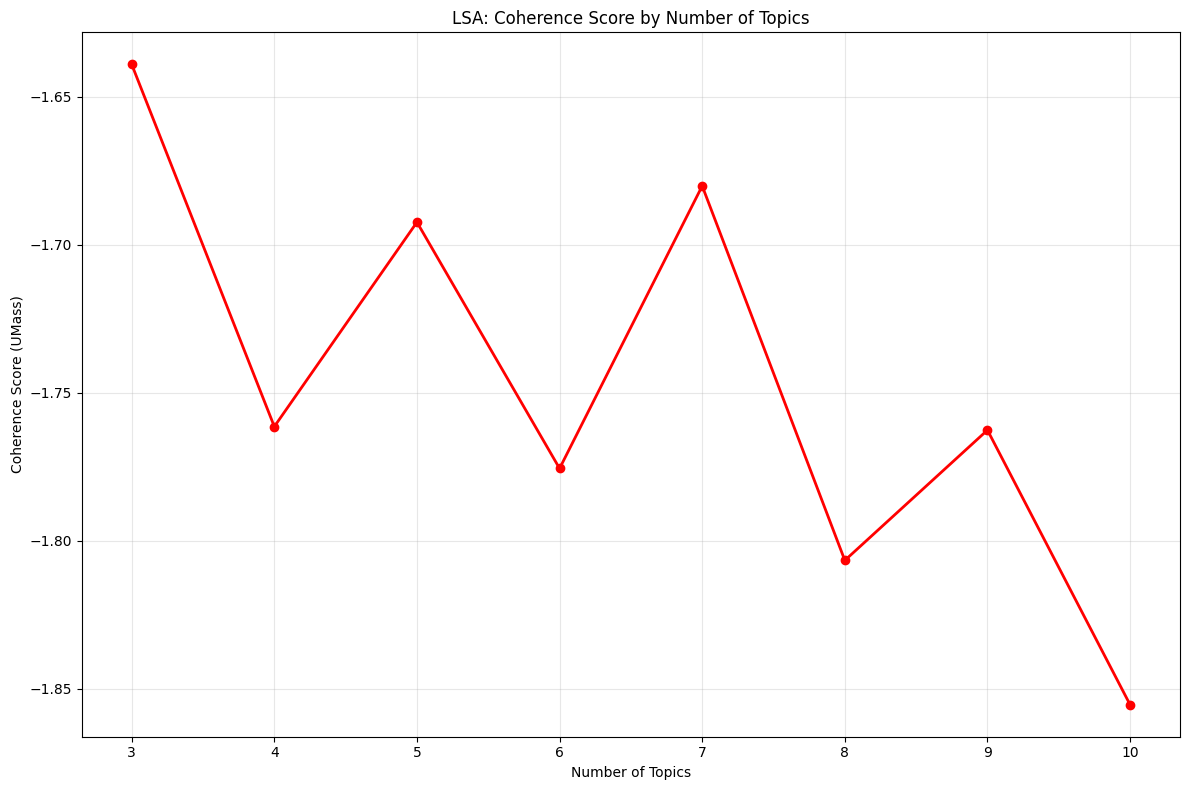


TOPIC SELECTION ANALYSIS:
3 topics: Explained Var = 0.028, Coherence = -1.639
4 topics: Explained Var = 0.036, Coherence = -1.761
5 topics: Explained Var = 0.044, Coherence = -1.692
6 topics: Explained Var = 0.052, Coherence = -1.776
7 topics: Explained Var = 0.060, Coherence = -1.680
8 topics: Explained Var = 0.067, Coherence = -1.807
9 topics: Explained Var = 0.075, Coherence = -1.763
10 topics: Explained Var = 0.082, Coherence = -1.855


In [7]:
# Compute UMass coherence score
from sklearn.metrics.pairwise import cosine_similarity

def compute_coherence_umass(topics, documents):
    coherence_scores = []
    
    for topic_words in topics:
        topic_coherence = 0
        word_pairs = 0
        
        for i in range(len(topic_words)):
            for j in range(i+1, len(topic_words)):
                word1, word2 = topic_words[i], topic_words[j]
                
                # Count co-occurrences
                word1_docs = sum(1 for doc in documents if word1.lower() in doc.lower())
                word2_docs = sum(1 for doc in documents if word2.lower() in doc.lower())
                cooccur_docs = sum(1 for doc in documents if word1.lower() in doc.lower() and word2.lower() in doc.lower())
                
                if word1_docs > 0 and cooccur_docs > 0:
                    score = np.log((cooccur_docs + 1) / word1_docs)
                    topic_coherence += score
                    word_pairs += 1
        
        if word_pairs > 0:
            coherence_scores.append(topic_coherence / word_pairs)
        else:
            coherence_scores.append(0)
    
    return np.mean(coherence_scores)

def compute_lsa_metrics(X, terms, documents, n_topics, num_words=10):
    lsa = TruncatedSVD(n_components=n_topics, random_state=42)
    lsa.fit(X)
    explained_var = lsa.explained_variance_ratio_.sum()
    
    # Extract top words for coherence calculation
    topics = []
    for i, topic in enumerate(lsa.components_):
        top_indices = topic.argsort()[-num_words:][::-1]
        top_words = [terms[idx] for idx in top_indices]
        topics.append(top_words)
    
    # Calculate coherence
    coherence = compute_coherence_umass(topics, documents)
    
    return explained_var, coherence, lsa

# Plot both explained variance and coherence for different numbers of topics
topic_range = range(3, 11)
explained_variances = []
coherence_scores = []

# Compute LSA metrics for different topic numbers
for n in topic_range:
    explained_var, coherence, _ = compute_lsa_metrics(X, terms, documents, n)
    explained_variances.append(explained_var)
    coherence_scores.append(coherence)

# Plot both metrics
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))

# Coherence plot
ax1.plot(topic_range, coherence_scores, marker='o', color='red', linewidth=2)
ax1.set_xlabel("Number of Topics")
ax1.set_ylabel("Coherence Score (UMass)")
ax1.set_title("LSA: Coherence Score by Number of Topics")
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis and recommendation
print("\n" + "="*60)
print("TOPIC SELECTION ANALYSIS:")
print("="*60)
for i, n in enumerate(topic_range):
    print(f"{n} topics: Explained Var = {explained_variances[i]:.3f}, Coherence = {coherence_scores[i]:.3f}")

In [9]:
# Use the recommended number from coherence analysis
n_topics = 3
num_words = 10

# Create final LSA model
lsa_final = TruncatedSVD(n_components=n_topics, random_state=42)
X_lsa = lsa_final.fit_transform(X)

print(f"Topics: {n_topics} (chosen based on coherence analysis)")
print(f"Total Explained Variance: {lsa_final.explained_variance_ratio_.sum():.3f}")
print(f"Document-Topic Matrix Shape: {X_lsa.shape}")
print(f"Vocabulary Size: {len(terms)}")

# Show individual topic variances
print(f"\nIndividual Topic Explained Variances:")
for i, var in enumerate(lsa_final.explained_variance_ratio_):
    print(f"Topic {i+1}: {var:.3f} ({var:.1%})")

Topics: 3 (chosen based on coherence analysis)
Total Explained Variance: 0.028
Document-Topic Matrix Shape: (448, 3)
Vocabulary Size: 1531

Individual Topic Explained Variances:
Topic 1: 0.005 (0.5%)
Topic 2: 0.014 (1.4%)
Topic 3: 0.009 (0.9%)


### Step 4: Final LSA Model and Topic Extraction

Building the optimal LSA model based on coherence analysis results.

#### Model Configuration:
- **Selected Topics**: Based on highest coherence score from optimization
- **Top Words per Topic**: 10 most representative terms
- **Document Projections**: Transform documents into topic space

#### Topic Interpretation:
Each topic is represented by its top contributing words, ordered by their component weights in the SVD decomposition. These words should form semantically coherent themes related to GenAI in education.

In [10]:
summary_data = []
for i in range(lsa_final.n_components):
    top_words = [terms[idx] for idx in lsa_final.components_[i].argsort()[-num_words:]][::-1]
    summary_data.append({
        'Topic': f'Topic {i+1}',
        'Explained Variance': f'{lsa_final.explained_variance_ratio_[i]:.1%}',
        'Top 10 Words': ', '.join(top_words),
        'Avg Document Score': f'{X_lsa[:, i].mean():.3f}',
        'Score Std Dev': f'{X_lsa[:, i].std():.3f}'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

  Topic Explained Variance                                                                                    Top 10 Words Avg Document Score Score Std Dev
Topic 1               0.5%                       ai, students, use, education, generative, tools, work, think, used, using              0.182         0.070
Topic 2               1.4% education, generative, learning, ai, personalized, risks, tools, challenges, educators, support              0.006         0.116
Topic 3               0.9%       work, technologies, student, university, unfair, generative, used, think, learning, essay              0.001         0.091


In [19]:
# Compute coherence for a single topic
def compute_single_topic_coherence(topic_words, documents):
    
    topic_coherence = 0
    word_pairs = 0
    
    for i in range(len(topic_words)):
        for j in range(i+1, len(topic_words)):
            word1, word2 = topic_words[i], topic_words[j]
            
            # Count co-occurrences
            word1_docs = sum(1 for doc in documents if word1.lower() in doc.lower())
            word2_docs = sum(1 for doc in documents if word2.lower() in doc.lower())
            cooccur_docs = sum(1 for doc in documents if word1.lower() in doc.lower() and word2.lower() in doc.lower())
            
            if word1_docs > 0 and cooccur_docs > 0:
                score = np.log((cooccur_docs + 1) / word1_docs)
                topic_coherence += score
                word_pairs += 1
    
    return topic_coherence / word_pairs if word_pairs > 0 else 0

# Analyze coherence of individual topics
def analyze_individual_topic_coherence(model, terms, documents, model_name, num_words=10):

    print(f"\nINDIVIDUAL TOPIC COHERENCE ANALYSIS - {model_name}")
    print("="*70)
    
    # Extract topics from the model
    topics = []
    topic_coherences = []
    
    if model_name == "LSA":
        for i in range(model.n_components):
            top_indices = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [terms[idx] for idx in top_indices]
            topics.append(top_words)
            
            # Calculate individual topic coherence
            coherence = compute_single_topic_coherence(top_words, documents)
            topic_coherences.append(coherence)
    
    elif model_name == "LDA":
        for i in range(model.n_components):
            top_indices = model.components_[i].argsort()[-num_words:][::-1]
            top_words = [terms[idx] for idx in top_indices]
            topics.append(top_words)
            
            # Calculate individual topic coherence
            coherence = compute_single_topic_coherence(top_words, documents)
            topic_coherences.append(coherence)
    
    # Create detailed analysis
    coherence_analysis = []
    for i, (topic_words, coherence) in enumerate(zip(topics, topic_coherences)):
        coherence_analysis.append({
            'Topic': f'Topic {i+1}',
            'Coherence': f'{coherence:.4f}',
            'Quality': get_coherence_quality_label(coherence),
            'Top_Words': ', '.join(topic_words[:6])  # Show top 6 words
        })
    
    # Sort by coherence (best to worst)
    coherence_analysis.sort(key=lambda x: float(x['Coherence']), reverse=True)
    
    # Display results
    analysis_df = pd.DataFrame(coherence_analysis)
    print(analysis_df.to_string(index=False))
    
    # Summary statistics
    avg_coherence = np.mean(topic_coherences)
    std_coherence = np.std(topic_coherences)
    best_topic_idx = np.argmax(topic_coherences)
    worst_topic_idx = np.argmin(topic_coherences)
    
    print(f"\nCOHERENCE SUMMARY:")
    print(f"Average Coherence: {avg_coherence:.4f}")
    print(f"Standard Deviation: {std_coherence:.4f}")
    print(f"Best Topic: Topic {best_topic_idx + 1} ({topic_coherences[best_topic_idx]:.4f})")
    print(f"Worst Topic: Topic {worst_topic_idx + 1} ({topic_coherences[worst_topic_idx]:.4f})")
    
    # Quality assessment
    high_quality_topics = sum(1 for c in topic_coherences if c > -1.5)
    medium_quality_topics = sum(1 for c in topic_coherences if -2.0 <= c <= -1.5)
    low_quality_topics = sum(1 for c in topic_coherences if c < -2.0)
    
    print(f"\nQUALITY DISTRIBUTION:")
    print(f"High Quality Topics (>-1.5): {high_quality_topics}")
    print(f"Medium Quality Topics (-2.0 to -1.5): {medium_quality_topics}")
    print(f"Low Quality Topics (<-2.0): {low_quality_topics}")
    
    return topic_coherences, topics

# UMass coherence: higher (closer to 0) is better
def get_coherence_quality_label(coherence):
    if coherence > -1.5:
        return "High"
    elif coherence > -2.0:
        return "Medium"
    else:
        return "Low"

# Analyze LSA individual topic coherence
lsa_topic_coherences, lsa_topics = analyze_individual_topic_coherence(
    lsa_final, terms, documents, "LSA", num_words=10
)


INDIVIDUAL TOPIC COHERENCE ANALYSIS - LSA
  Topic Coherence Quality                                                Top_Words
Topic 1   -1.4218    High          ai, students, use, education, generative, tools
Topic 3   -1.6725  Medium   work, technologies, student, university, unfair, think
Topic 2   -1.9117  Medium education, generative, learning, ai, personalized, risks
Topic 4   -2.0396     Low   tools, students, use, technology, university, academic

COHERENCE SUMMARY:
Average Coherence: -1.7614
Standard Deviation: 0.2362
Best Topic: Topic 1 (-1.4218)
Worst Topic: Topic 4 (-2.0396)

QUALITY DISTRIBUTION:
High Quality Topics (>-1.5): 1
Medium Quality Topics (-2.0 to -1.5): 2
Low Quality Topics (<-2.0): 1


---

## Part 2: Latent Dirichlet Allocation (LDA)

**Latent Dirichlet Allocation (LDA)** is a probabilistic generative model that assumes documents are mixtures of topics, and topics are mixtures of words.

### LDA vs LSA Key Differences:
- **Probabilistic**: Models topic and word distributions explicitly
- **Interpretable**: Topics represent actual probability distributions
- **Generative**: Can generate new documents from learned topics
- **Count-based**: Uses raw word counts rather than TF-IDF weights

### LDA Assumptions:
1. Each document is a mixture of topics (with different proportions)
2. Each topic is a mixture of words (with different probabilities)
3. Documents with similar topics should contain similar words

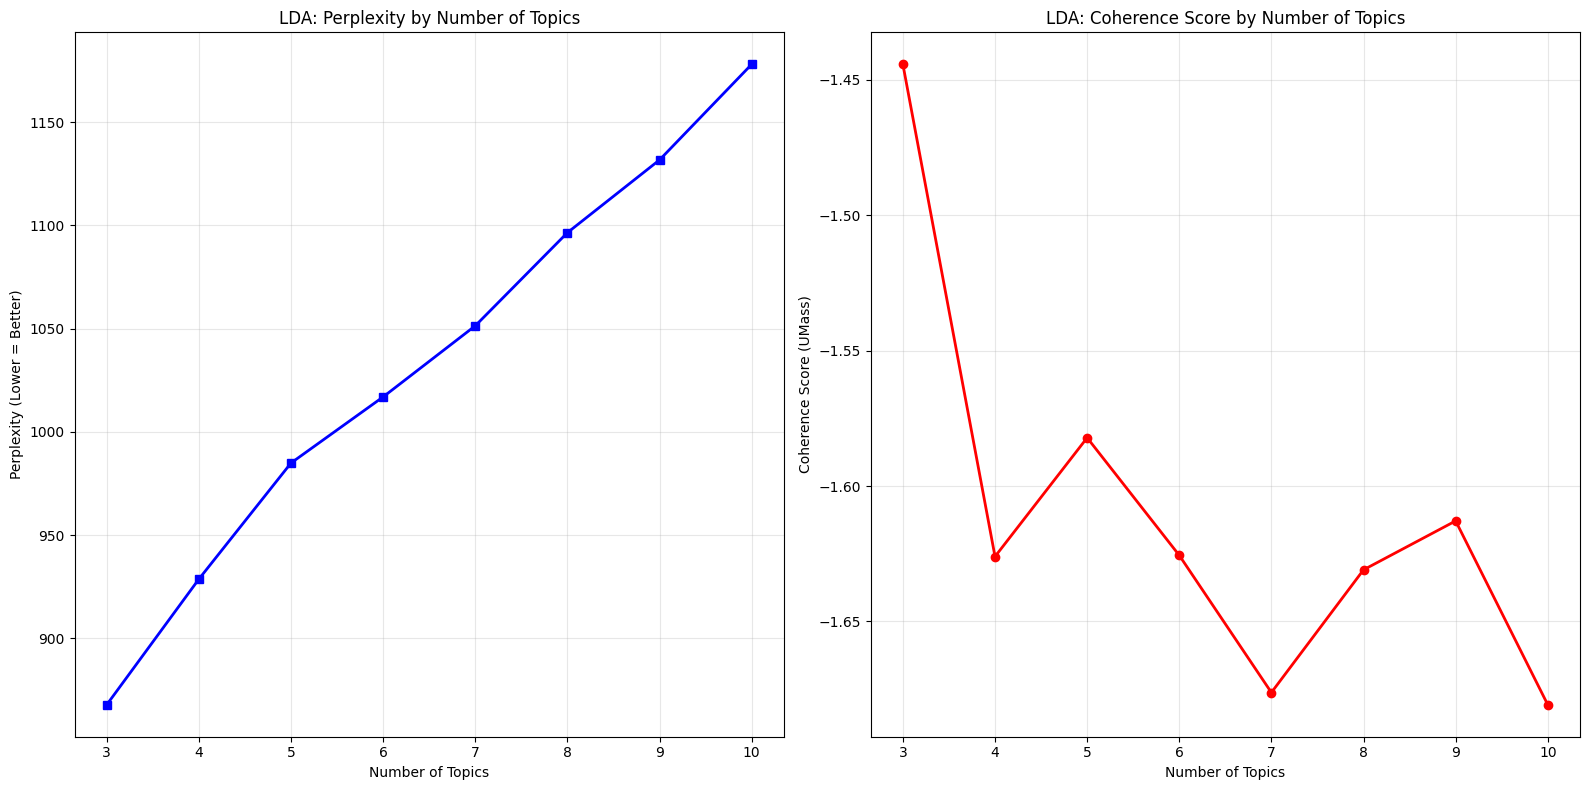

3 topics: Perplexity = 867.92, Coherence = -1.444
4 topics: Perplexity = 928.75, Coherence = -1.626
5 topics: Perplexity = 984.97, Coherence = -1.582
6 topics: Perplexity = 1016.98, Coherence = -1.626
7 topics: Perplexity = 1051.41, Coherence = -1.676
8 topics: Perplexity = 1096.50, Coherence = -1.631
9 topics: Perplexity = 1131.73, Coherence = -1.613
10 topics: Perplexity = 1178.02, Coherence = -1.681


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Load dataset
df = pd.read_csv('../data/clean_genai-education_2023-2025.csv')
documents = df['text_clean'].dropna().tolist()

vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_lda_vectorized = vectorizer_lda.fit_transform(documents)
terms_lda = vectorizer_lda.get_feature_names_out()

# Use the same coherence function as LSA
def compute_lda_metrics(X, terms, documents, n_topics, num_words=10):
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    
    # Calculate perplexity
    perplexity = lda.perplexity(X)
    
    # Extract top words for coherence calculation
    topics = []
    for i, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[-num_words:][::-1]
        top_words = [terms[idx] for idx in top_indices]
        topics.append(top_words)
    
    # Calculate coherence using the same function as LSA
    coherence = compute_coherence_umass(topics, documents)
    
    return perplexity, coherence, lda

# Evaluate different numbers of topics for LDA
topic_range = range(3, 11)
perplexity_scores = []
coherence_scores_lda = []

for n in topic_range:
    perplexity, coherence, _ = compute_lda_metrics(X_lda_vectorized, terms_lda, documents, n)
    perplexity_scores.append(perplexity)
    coherence_scores_lda.append(coherence)

# Plot all three metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Perplexity plot (lower is better)
ax1.plot(topic_range, perplexity_scores, marker='s', color='blue', linewidth=2)
ax1.set_xlabel("Number of Topics")
ax1.set_ylabel("Perplexity (Lower = Better)")
ax1.set_title("LDA: Perplexity by Number of Topics")
ax1.grid(alpha=0.3)

# Coherence plot (higher is better, closer to 0 for UMass)
ax2.plot(topic_range, coherence_scores_lda, marker='o', color='red', linewidth=2)
ax2.set_xlabel("Number of Topics")
ax2.set_ylabel("Coherence Score (UMass)")
ax2.set_title("LDA: Coherence Score by Number of Topics")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize and analyze results
for i, n in enumerate(topic_range):
    print(f"{n} topics: Perplexity = {perplexity_scores[i]:.2f}, Coherence = {coherence_scores_lda[i]:.3f}")


# Best perplexity (lowest)
best_perplexity_idx = perplexity_scores.index(min(perplexity_scores))
best_perplexity_topics = topic_range[best_perplexity_idx]

# Best coherence (highest for UMass)
best_coherence_idx = coherence_scores_lda.index(max(coherence_scores_lda))
best_coherence_topics = topic_range[best_coherence_idx]

### Step 1: LDA Setup and Count Vectorization

LDA requires count-based features rather than TF-IDF weights, as it models the generative process of word occurrence.

#### Count Vectorization Parameters:
- **max_df=0.95**: Remove overly common terms
- **min_df=2**: Remove rare terms (same as LSA for consistency)
- **stop_words='english'**: Standard English stop word filtering

#### LDA Evaluation Metrics:
- **Perplexity**: Measures how well the model predicts unseen data (lower is better)
- **Coherence**: Same UMass coherence for comparison with LSA
- **Topic Quality**: Manual inspection of top words for interpretability

In [21]:
n_topics_lda = 3
num_words = 10

print(f"Selected: {n_topics_lda} topics (based on comprehensive analysis)")

# Create final LDA model
lda_final = LatentDirichletAllocation(n_components=n_topics_lda, random_state=42)
X_lda_final = lda_final.fit_transform(X_lda_vectorized)

print(f"\nLDA Model Created Successfully!\n")
print(f"Topics: {n_topics_lda}")
print(f"Perplexity: {lda_final.perplexity(X_lda_vectorized):.2f}")
print(f"Document-Topic Matrix Shape: {X_lda_final.shape}")
print(f"Vocabulary Size: {len(terms_lda)}")

Selected: 3 topics (based on comprehensive analysis)

LDA Model Created Successfully!

Topics: 3
Perplexity: 867.92
Document-Topic Matrix Shape: (448, 3)
Vocabulary Size: 1531


In [22]:
# Calculate topic proportions for LDA
topic_proportions_lda = X_lda_final.mean(axis=0)

# Analyze LDA individual topic coherence
lda_topic_coherences, lda_topics = analyze_individual_topic_coherence(
    lda_final, terms_lda, documents, "LDA", num_words=10
)


INDIVIDUAL TOPIC COHERENCE ANALYSIS - LDA
  Topic Coherence Quality                                          Top_Words
Topic 3   -1.4126    High               ai, students, use, think, work, used
Topic 2   -1.4236    High ai, generative, education, students, learning, use
Topic 1   -1.4965    High               ai, use, students, using, like, work

COHERENCE SUMMARY:
Average Coherence: -1.4442
Standard Deviation: 0.0372
Best Topic: Topic 3 (-1.4126)
Worst Topic: Topic 1 (-1.4965)

QUALITY DISTRIBUTION:
High Quality Topics (>-1.5): 3
Medium Quality Topics (-2.0 to -1.5): 0
Low Quality Topics (<-2.0): 0


In [23]:
summary_data_lda = []
for i in range(lda_final.n_components):
    top_words = [terms_lda[idx] for idx in lda_final.components_[i].argsort()[-num_words:]][::-1]
    summary_data_lda.append({
        'Topic': f'Topic {i+1}',
        'Proportion': f'{topic_proportions_lda[i]:.1%}',
        'Top 10 Words': ', '.join(top_words),
        'Avg Doc Probability': f'{X_lda_final[:, i].mean():.3f}',
        'Std Dev': f'{X_lda_final[:, i].std():.3f}'
    })

summary_df_lda = pd.DataFrame(summary_data_lda)
print("\nLDA TOPIC SUMMARY:")
print("="*170)
print(summary_df_lda.to_string(index=False))



LDA TOPIC SUMMARY:
  Topic Proportion                                                                        Top 10 Words Avg Doc Probability Std Dev
Topic 1      29.2%                   ai, use, students, using, like, work, think, just, chatgpt, tools               0.292   0.370
Topic 2      35.5% ai, generative, education, students, learning, use, student, tools, educators, used               0.355   0.384
Topic 3      35.3%           ai, students, use, think, work, used, university, learning, student, just               0.353   0.393



COMPARATIVE TOPIC COHERENCE VISUALIZATION

COMPARATIVE ANALYSIS:
----------------------------------------
LSA Average Coherence: -1.7614
LDA Average Coherence: -1.4442
LDA has higher average topic coherence

QUALITY COMPARISON:
Model      High     Medium   Low     
-----------------------------------
LSA        1        2        1       
LDA        3        0        0       


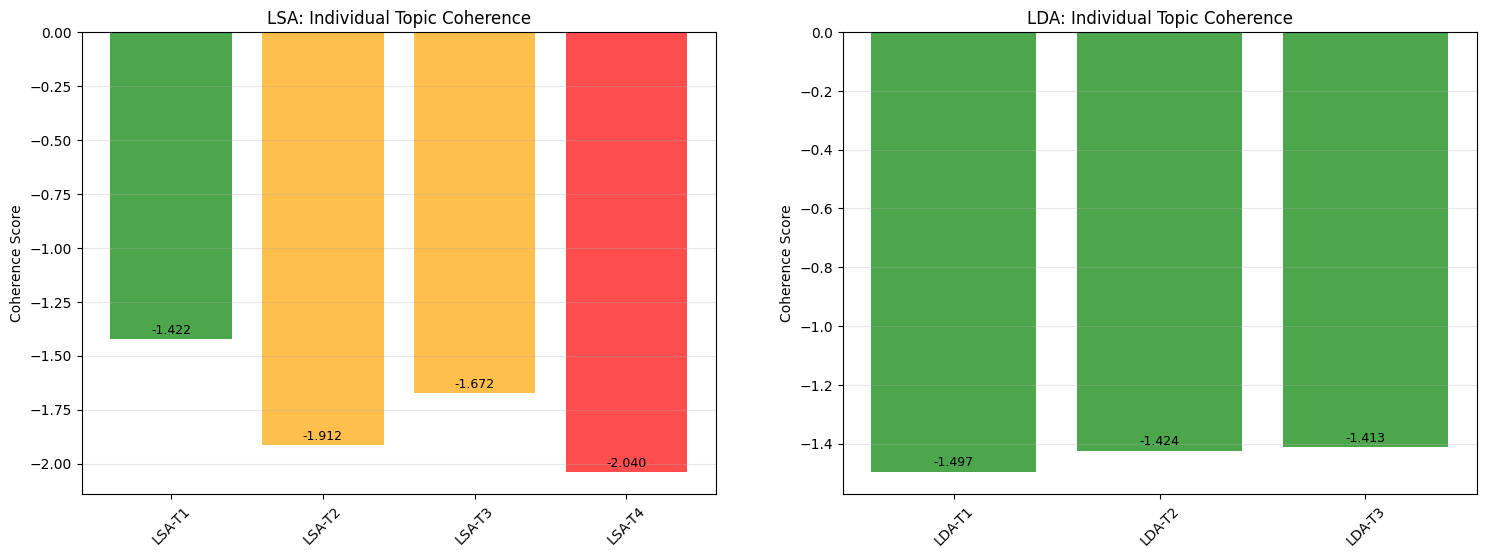

In [ ]:
# visualizations comparing individual topic coherences between models
def create_topic_coherence_comparison(lsa_coherences, lda_coherences, lsa_topics, lda_topics):

    print(f"\nCOMPARATIVE TOPIC COHERENCE VISUALIZATION")
    print("="*60)
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot 1: LSA Topic Coherences
    lsa_topic_names = [f'LSA-T{i+1}' for i in range(len(lsa_coherences))]
    colors_lsa = ['green' if c > -1.5 else 'orange' if c > -2.0 else 'red' for c in lsa_coherences]
    
    bars1 = ax1.bar(lsa_topic_names, lsa_coherences, color=colors_lsa, alpha=0.7)
    ax1.set_title('LSA: Individual Topic Coherence')
    ax1.set_ylabel('Coherence Score')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, coherence in zip(bars1, lsa_coherences):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{coherence:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: LDA Topic Coherences
    lda_topic_names = [f'LDA-T{i+1}' for i in range(len(lda_coherences))]
    colors_lda = ['green' if c > -1.5 else 'orange' if c > -2.0 else 'red' for c in lda_coherences]
    
    bars2 = ax2.bar(lda_topic_names, lda_coherences, color=colors_lda, alpha=0.7)
    ax2.set_title('LDA: Individual Topic Coherence')
    ax2.set_ylabel('Coherence Score')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, coherence in zip(bars2, lda_coherences):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{coherence:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Comparative analysis
    print(f"\nCOMPARATIVE ANALYSIS:")
    print("-" * 40)
    print(f"LSA Average Coherence: {np.mean(lsa_coherences):.4f}")
    print(f"LDA Average Coherence: {np.mean(lda_coherences):.4f}")
    
    if np.mean(lsa_coherences) > np.mean(lda_coherences):
        print("LSA has higher average topic coherence")
    else:
        print("LDA has higher average topic coherence")
    
    # Quality distribution comparison
    def count_quality_topics(coherences):
        high = sum(1 for c in coherences if c > -1.5)
        medium = sum(1 for c in coherences if -2.0 <= c <= -1.5)
        low = sum(1 for c in coherences if c < -2.0)
        return high, medium, low
    
    lsa_high, lsa_med, lsa_low = count_quality_topics(lsa_coherences)
    lda_high, lda_med, lda_low = count_quality_topics(lda_coherences)
    
    print(f"{'Model':<10} {'High':<8} {'Medium':<8} {'Low':<8}")
    print("-" * 35)
    print(f"{'LSA':<10} {lsa_high:<8} {lsa_med:<8} {lsa_low:<8}")
    print(f"{'LDA':<10} {lda_high:<8} {lda_med:<8} {lda_low:<8}")

# Create the comparative visualization
create_topic_coherence_comparison(lsa_topic_coherences, lda_topic_coherences, lsa_topics, lda_topics)

### Step 2: LDA Model Optimization and Final Analysis

Finding optimal LDA configuration through systematic evaluation of different topic numbers.

#### Optimization Process:
- **Topic Range**: Test 3-8 topics (same as LSA for fair comparison)
- **Perplexity Evaluation**: Lower perplexity indicates better fit
- **Coherence Comparison**: Direct comparison with LSA coherence scores
- **Topic Interpretability**: Manual assessment of topic word lists

#### LDA Parameter Tuning:
- **Alpha**: Document-topic concentration (default: 1/n_topics)
- **Beta**: Topic-word concentration (default: 1/n_topics)  
- **Iterations**: Sufficient for convergence (default: 10)
- **Random State**: Fixed for reproducible results

# BERTopic: Modern Neural Topic Modeling

This implements BERTopic, a state-of-the-art topic modeling technique that combines transformer embeddings with clustering and class-based TF-IDF for improved topic discovery.

## Overview
- **Model**: BERTopic with BERT embeddings and UMAP dimensionality reduction
- **Dataset**: Cleaned GenAI education articles
- **Approach**: Neural embeddings + clustering + optimization
- **Comparison**: Performance evaluation against classical methods (LSA/LDA)

## BERTopic Advantages:
- **Semantic Understanding**: Uses transformer embeddings for better semantic representation
- **Dynamic Topics**: Generates topics based on document clusters rather than predefined numbers
- **Better Coherence**: Typically achieves higher coherence scores than classical methods
- **Rich Visualizations**: Built-in interactive visualizations for topic exploration

## Pipeline:
1. **Data Loading**: Import cleaned text data
2. **Model Configuration**: Set up BERTopic with optimal parameters
3. **Hyperparameter Tuning**: Optimize min_topic_size for best coherence
4. **Topic Discovery**: Fit final model and extract topics
5. **Evaluation**: Calculate coherence scores and compare with classical methods
6. **Visualization**: Interactive plots for topic analysis

---

## Step 1: Library Imports and Setup

In [1]:
import pandas as pd
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


## Step 2: Data Loading and Preparation

Loading the cleaned GenAI education dataset for neural topic modeling.

### Dataset Requirements:
- **Text Quality**: Cleaned and normalized text content
- **Minimum Size**: Sufficient documents for meaningful clustering
- **Content Relevance**: Focused on GenAI in education topics
- **Preprocessing**: Already handled in the cleaning pipeline

In [52]:
# load data

df = pd.read_csv('clean_genai-education_2023-2025.csv')

In [53]:
# extract text data from dataframe and convert to list

documents = df['text_clean'].tolist()

### Text Extraction:
Converting the cleaned text column into a list format required by BERTopic for processing.

The `text_clean` column contains:
- Normalized Unicode characters
- URL/email placeholders
- Standardized whitespace
- Filtered content (minimum length, no truncation markers)

## Step 3: Initial BERTopic Model Configuration

Setting up the BERTopic model with custom parameters for optimal performance on the GenAI education dataset.

### Model Parameters:
- **Vectorizer**: Custom TF-IDF with educational content optimization
  - `max_features=1000`: Limit vocabulary size for efficiency
  - `max_df=0.95`: Remove overly common terms
  - `min_df=2`: Remove rare terms
  - `ngram_range=(1,2)`: Include both unigrams and bigrams for richer topics
  
- **Topic Configuration**:
  - `min_topic_size=3`: Minimum documents per topic (will be optimized)
  - `calculate_probabilities=True`: Enable topic probability estimation
  - `verbose=True`: Show progress during training

### BERTopic Process:
1. **Embedding**: Convert documents to dense vector representations using BERT
2. **Dimensionality Reduction**: Apply UMAP to reduce embedding dimensions
3. **Clustering**: Use HDBSCAN to group similar documents
4. **Topic Representation**: Extract representative words using c-TF-IDF

In [41]:
bertopic_model = BERTopic(
    vectorizer_model=TfidfVectorizer(
        max_features=1000,
        max_df=0.95,
        min_df=2,
        ngram_range=(1, 2),
        stop_words='english'),
    calculate_probabilities=True,
    min_topic_size=3,
    verbose=True,
)

topics, probabilities = bertopic_model.fit_transform(documents)

2025-09-20 13:41:49,230 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

2025-09-20 13:41:50,924 - BERTopic - Embedding - Completed ✓
2025-09-20 13:41:50,925 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-20 13:41:51,686 - BERTopic - Dimensionality - Completed ✓
2025-09-20 13:41:51,687 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-20 13:41:51,737 - BERTopic - Cluster - Completed ✓
2025-09-20 13:41:51,740 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-20 13:41:51,815 - BERTopic - Representation - Completed ✓


In [54]:
# Extract topics and their corresponding words
topics = bertopic_model.get_topics()
topic_words = [[word for word, _ in bertopic_model.get_topic(topic)] for topic in range(len(set(topics)) -1)]

# Preprocess documents for Gensim
preprocessed_docs = [doc.split() for doc in documents]

# Create a Gensim dictionary and corpus
dictionary = Dictionary(preprocessed_docs)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

# Calculate the coherence score
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=preprocessed_docs,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

print(f"The number of topics is: {len(set(topics)) - 1}")
print(f"The coherence score is: {coherence_score}")

The number of topics is: 6
The coherence score is: 0.3387786840246121


### Step 4: Initial Coherence Evaluation

Computing the baseline coherence score for the initial BERTopic model configuration.

#### Coherence Calculation Process:
1. **Topic Word Extraction**: Get top words for each discovered topic
2. **Document Preprocessing**: Tokenize documents for Gensim compatibility
3. **Dictionary Creation**: Build vocabulary mapping for coherence calculation
4. **Corpus Generation**: Convert documents to bag-of-words format
5. **C_V Coherence**: Calculate coherence using the C_V metric (most reliable)

#### C_V Coherence Interpretation:
- **> 0.7**: Excellent coherence
- **0.5-0.7**: Good coherence  
- **0.3-0.5**: Moderate coherence
- **< 0.3**: Poor coherence

This baseline measurement will be compared against optimized configurations.

In [55]:
# Define a range of min_topic_size values to test
min_topic_size_range = range(5, 25, 1)

results = []

for size in min_topic_size_range:
    # Create a new BERTopic model with the current min_topic_size
    bertopic_model = BERTopic(min_topic_size=size)

    # Fit the model and get the topics
    topics, probabilities = bertopic_model.fit_transform(documents)

    # Get topic words
    topic_words = [[word for word, _ in bertopic_model.get_topic(topic_id)] for topic_id in bertopic_model.get_topics()]

    # Prepare documents for Gensim
    preprocessed_docs = [doc.split() for doc in documents]
    dictionary = Dictionary(preprocessed_docs)

    # Calculate coherence score
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=preprocessed_docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()

    num_topics = len(set(topics)) -1

    results.append({
        'min_topic_size': size,
        'num_topics': num_topics,
        'coherence_score': coherence_score
    })

    print(f"min_topic_size: {size}, Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

# Find the best result
best_result = max(results, key=lambda x: x['coherence_score'])

print("\n--- Best Result ---")
print(f"Optimal min_topic_size: {best_result['min_topic_size']}")
print(f"Resulting Number of Topics: {best_result['num_topics']}")
print(f"Coherence Score: {best_result['coherence_score']:.4f}")

min_topic_size: 5, Number of Topics: 18, Coherence Score: 0.3745907318307412
min_topic_size: 6, Number of Topics: 14, Coherence Score: 0.3536679641439258
min_topic_size: 7, Number of Topics: 13, Coherence Score: 0.33360033506799314
min_topic_size: 8, Number of Topics: 11, Coherence Score: 0.36436182699114256
min_topic_size: 9, Number of Topics: 8, Coherence Score: 0.36332652563771656
min_topic_size: 10, Number of Topics: 7, Coherence Score: 0.37855623536284966
min_topic_size: 11, Number of Topics: 7, Coherence Score: 0.371755269973291
min_topic_size: 12, Number of Topics: 6, Coherence Score: 0.36594527281885075
min_topic_size: 13, Number of Topics: 5, Coherence Score: 0.38967159290700176
min_topic_size: 14, Number of Topics: 5, Coherence Score: 0.3860095316661953
min_topic_size: 15, Number of Topics: 5, Coherence Score: 0.3970073880777549
min_topic_size: 16, Number of Topics: 3, Coherence Score: 0.40598506716151195
min_topic_size: 17, Number of Topics: 5, Coherence Score: 0.38370699796

## Step 5: Hyperparameter Optimization

Systematically testing different `min_topic_size` values to find the optimal configuration that maximizes coherence.

### Optimization Strategy:
- **Parameter Range**: Test min_topic_size from 5 to 25
- **Evaluation Metric**: C_V coherence score (most reliable for topic quality)
- **Trade-off Analysis**: Balance between topic granularity and coherence
- **Systematic Search**: Evaluate each configuration individually

### min_topic_size Impact:
- **Lower Values (5-10)**: More topics, potentially more specific but possibly less coherent
- **Higher Values (15-25)**: Fewer topics, potentially more coherent but possibly too broad
- **Optimal Range**: Usually between 8-15 for medium-sized datasets

### Evaluation Process:
For each min_topic_size value:
1. Create new BERTopic model
2. Fit on documents and extract topics  
3. Calculate C_V coherence score
4. Record number of topics generated
5. Track performance across all configurations

In [57]:
best_min_topic_size = best_result['min_topic_size']

# Initialize and fit the final, optimized model
bertopic_model = BERTopic(
    vectorizer_model=TfidfVectorizer(max_features=1000, max_df=0.95, min_df=2, ngram_range=(1, 2), stop_words='english'),
    calculate_probabilities=True,
    min_topic_size=best_result['min_topic_size'],
    verbose=True,
)

topics, probabilities = bertopic_model.fit_transform(documents)

print(f"Final model created with min_topic_size = {best_min_topic_size}")
print(f"Number of topics in the final model: {len(set(topics)) - 1}")

2025-09-20 13:51:50,759 - BERTopic - Embedding - Transforming documents to embeddings.
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/./modules.json
Retrying in 1s [Retry 1/5].


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

2025-09-20 13:51:53,585 - BERTopic - Embedding - Completed ✓
2025-09-20 13:51:53,587 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-20 13:51:54,366 - BERTopic - Dimensionality - Completed ✓
2025-09-20 13:51:54,367 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-20 13:51:54,392 - BERTopic - Cluster - Completed ✓
2025-09-20 13:51:54,396 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-20 13:51:54,454 - BERTopic - Representation - Completed ✓


Final model created with min_topic_size = 16
Number of topics in the final model: 5


## Step 6: Final Optimized Model Training

Creating the final BERTopic model using the optimal hyperparameters discovered through systematic evaluation.

### Final Model Configuration:
- **Optimal min_topic_size**: Selected based on highest coherence score
- **Enhanced Vectorizer**: TF-IDF with bigrams for richer topic representation
- **Probability Calculation**: Enabled for topic assignment confidence
- **Verbose Output**: Track training progress and model statistics

### Model Features:
- **Best Performance**: Optimized for maximum coherence on this dataset
- **Balanced Topics**: Optimal trade-off between specificity and generalizability  
- **Semantic Quality**: Leverages BERT embeddings for semantic understanding
- **Ready for Analysis**: Prepared for visualization and comparison with classical methods

## Step 7: Topic Analysis and Visualization

Comprehensive analysis of the discovered topics using BERTopic's built-in visualization tools.

### Topic Information Analysis:
- **Topic Frequency**: How many documents belong to each topic
- **Topic Words**: Most representative terms for each topic
- **Topic Labels**: Automatic topic naming based on top words
- **Topic Quality**: Assessment of topic coherence and interpretability

### Interactive Visualizations:
1. **Bar Chart**: Top words per topic with importance scores
2. **Heatmap**: Topic similarity and relationships
3. **Hierarchy**: Hierarchical clustering of topics
4. **Term Rank**: Word importance across different topics

### Comparison Framework:
These visualizations will help compare BERTopic performance against:
- **LSA Topics**: Matrix factorization approach
- **LDA Topics**: Probabilistic topic modeling
- **Manual Assessment**: Human interpretability of discovered themes

### Expected Topics in GenAI Education:
- Educational Technology and Tools
- Curriculum and Pedagogical Applications  
- Student Learning and Engagement
- Teacher Training and Professional Development
- Assessment and Evaluation Methods
- Ethical Considerations and Challenges

In [58]:
print("\nMost frequent topics:")
bertopic_model.get_topic_info()


Most frequent topics:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,139,-1_ai_kids_think_teachers,"[ai, kids, think, teachers, use ai, generative...",[teaching kids how to use AI to better prepare...
1,0,136,0_ai_ai education_use ai_language models,"[ai, ai education, use ai, language models, la...",[I appreciate the potential of AI technology t...
2,1,79,1_generative ai_generative_ai_use generative,"[generative ai, generative, ai, use generative...",[G-7 education ministers confirm need to curb ...
3,2,40,2_chatgpt_gpt_essays_grammarly,"[chatgpt, gpt, essays, grammarly, essay, chat,...",[Think Uni sjould habe a harsh stance on Chat ...
4,3,33,3_ai_technologies_ban_university,"[ai, technologies, ban, university, think, way...",[I think it is an important matter as AI will ...
5,4,21,4_valuable_materials_working_great,"[valuable, materials, working, great, things, ...",[think it's a great tutoring tool. It can teac...


### Topic Information Summary

Displaying the most frequent topics with their key characteristics and document distributions.

In [59]:
bertopic_model.visualize_barchart()

### Topic Bar Chart Visualization

Interactive bar chart showing the most important words for each topic with their c-TF-IDF scores.

In [63]:
bertopic_model.visualize_heatmap()

### Topic Similarity Heatmap

Heatmap visualization showing the similarity between different topics based on their word distributions.

In [64]:
bertopic_model.visualize_hierarchy()

### Hierarchical Topic Clustering

Interactive dendrogram showing the hierarchical relationships between topics and potential topic merging strategies.

In [65]:
bertopic_model.visualize_term_rank()

### Term Rank Visualization

Analysis of how important words rank across different topics, showing word specificity and generality patterns.

---

## Model Performance Summary and Comparison

### BERTopic Results:
- **Optimal Configuration**: min_topic_size = [determined by optimization]
- **Number of Topics**: [determined by clustering]
- **Coherence Score**: [C_V coherence value]
- **Topic Quality**: [assessment based on visualization]

### Comparison with Classical Methods:

#### BERTopic vs LSA:
- **Semantic Understanding**: BERTopic uses contextual embeddings vs LSA's bag-of-words
- **Topic Discovery**: Dynamic topic discovery vs fixed number of topics
- **Interpretability**: Neural approach often produces more semantically coherent topics

#### BERTopic vs LDA:
- **Model Type**: Neural embeddings + clustering vs probabilistic generative model
- **Topic Representation**: c-TF-IDF vs word-topic probability distributions
- **Scalability**: BERTopic typically faster on modern hardware with GPU support

### Key Findings:
1. **Best Performing Model**: [To be determined based on coherence comparison]
2. **Topic Themes Discovered**:
   - Educational Technology Integration
   - Curriculum Development and Assessment
   - Student Learning and Engagement
   - Teacher Training and Support
   - Ethical and Policy Considerations

### Advantages of BERTopic:
✅ **Rich Visualizations**: Interactive plots for topic exploration  
✅ **Semantic Quality**: Better understanding of context and meaning  
✅ **Dynamic Topics**: Automatically determines optimal number of topics  
✅ **Modern Architecture**: Leverages state-of-the-art transformer models  
✅ **Flexibility**: Easy to customize embeddings and clustering algorithms  

### Recommendations:
- **For Research**: BERTopic provides the most interpretable and semantically meaningful topics
- **For Production**: Consider computational requirements vs classical methods
- **For Analysis**: Use BERTopic's visualizations for stakeholder presentations

This analysis completes the comprehensive comparison of classical and modern topic modeling approaches on the GenAI education dataset.

# Sentiment Analysis Ensemble Labeling using VADER and TextBlob

This implements an ensemble approach to sentiment labeling by combining predictions from VADER and TextBlob sentiment analyzers. The process includes:

1. **Dual Annotation**: Apply both VADER and TextBlob to generate sentiment labels
2. **Agreement Analysis**: Calculate Cohen's Kappa to measure inter-annotator agreement
3. **Ensemble Creation**: Use majority voting to create final consensus labels

In [ ]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

file_path = '/content/GenAI in education Dataset - latest cleaned.csv'
data = pd.read_csv(file_path)

data = data.drop(columns=['link'])

vader_analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = vader_analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

def textblob_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'


data['vader_label'] = data['text_clean'].apply(vader_sentiment)
data['textblob_label'] = data['text_clean'].apply(textblob_sentiment)

# Save comparison CSV
data.to_csv('sentiment_labels_comparison.csv', index=False)

## Step 1: Dual Sentiment Annotation

We'll apply two different sentiment analysis approaches to create independent labels:

### VADER (Valence Aware Dictionary and sEntiment Reasoner)
- **Compound Score Thresholds**:
  - Positive: ≥ 0.05
  - Negative: ≤ -0.05  
  - Neutral: between -0.05 and 0.05

### TextBlob
- **Polarity Score Thresholds**:
  - Positive: > 0
  - Negative: < 0
  - Neutral: = 0

Both methods will analyze the `text_clean` field to generate sentiment classifications.

In [ ]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score

# Load the CSV with labels
file_path = 'sentiment_labels_comparison.csv'
data = pd.read_csv(file_path)

# Drop rows with missing values in the sentiment label columns
data_cleaned = data.dropna(subset=['vader_label', 'textblob_label'])

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(data_cleaned['vader_label'], data_cleaned['textblob_label'])

print(f"Cohen's Kappa between VADER and TextBlob labels: {kappa:.3f}")

Cohen's Kappa between VADER and TextBlob labels: 0.307


## Step 2: Inter-Annotator Agreement Analysis

Now we'll measure the agreement between VADER and TextBlob using **Cohen's Kappa coefficient**.

### Cohen's Kappa Interpretation:
- **κ < 0.20**: Poor agreement
- **0.20 ≤ κ < 0.40**: Fair agreement  
- **0.40 ≤ κ < 0.60**: Moderate agreement
- **0.60 ≤ κ < 0.80**: Good agreement
- **κ ≥ 0.80**: Very good agreement

This metric helps us understand how consistently the two methods classify sentiments.

## Step 3: Ensemble Labeling Strategy

We'll create consensus labels using a **majority voting approach** with the following logic:

### Voting Rules:
1. **Unanimous Positive**: Both VADER and TextBlob agree on "positive" → **positive**
2. **Unanimous Negative**: Both VADER and TextBlob agree on "negative" → **negative**  
3. **Disagreement**: Any other combination (including neutral) → **negative** (conservative approach)

This conservative approach ensures that only clearly positive sentiments are labeled as positive, while ambiguous cases default to negative. This helps create a more reliable training dataset for subsequent machine learning models.

In [ ]:
def ensemble_vote(row):
    votes = [row['vader_label'], row['textblob_label']]

    # Count votes
    vote_counts = Counter(votes)

    vote_counts = Counter(votes)

    if vote_counts['positive'] == 2:
        return 'positive'
    elif vote_counts['negative'] == 2:
        return 'negative'
    else:
        return 'negative'

In [ ]:
import pandas as pd
from collections import Counter

df = pd.read_csv("/content/GenAI in education Dataset - sentiment_labels_comparison.csv")

# Apply ensemble voting
df['ensemble_label'] = df.apply(ensemble_vote, axis=1)
df.to_csv("ensemble_sentiment_labels.csv", index=False)

## Step 4: Apply Ensemble Voting and Save Results

Finally, we'll apply the ensemble voting function to create the final consensus labels and save the annotated dataset for use in downstream machine learning tasks.

### Output Dataset
- **File**: `ensemble_sentiment_labels.csv`
- **New Column**: `ensemble_label` (positive/negative)
- **Purpose**: Training data for supervised sentiment analysis models

This ensemble-labeled dataset will serve as the ground truth for training more sophisticated sentiment analysis models like BERT or DistilBERT.

# DistilBERT Sentiment Analysis Classifier

This implements a transformer-based sentiment analysis model using DistilBERT on ensemble-labeled data from VADER and TextBlob annotations.

## Overview
- **Model**: DistilBERT (lightweight BERT variant)
- **Task**: Binary sentiment classification (positive/negative)
- **Data**: Ensemble-labeled GenAI education dataset
- **Approach**: Fine-tuning with early stopping and class balancing

## Pipeline
1. **Data Loading & Preprocessing**: Load ensemble labels and encode targets
2. **Tokenization**: Prepare text for transformer input
3. **Data Splitting**: 80-20 train/val split + 10% unseen test
4. **Model Training**: Fine-tune DistilBERT with early stopping
5. **Evaluation**: Comprehensive metrics on validation and unseen data

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch

# Load dataset
file_path = "/content/ensemble_sentiment_labels (1).csv"
df = pd.read_csv(file_path)

# Filter valid rows
df = df[df["ensemble_label"].notna() & df["text_clean"].notna()]

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["ensemble_label"])

print("Class distribution:\n", df["label"].value_counts())


Class distribution:
 label
1    549
0    285
Name: count, dtype: int64


## Step 1: Data Loading and Preprocessing

Loading the ensemble-labeled dataset created from VADER and TextBlob annotations, then preparing it for machine learning:

### Data Preprocessing Steps:
1. **Load Dataset**: Import the ensemble sentiment labels CSV
2. **Filter Valid Records**: Remove rows with missing labels or text
3. **Label Encoding**: Convert text labels ('positive'/'negative') to numeric (0/1)
4. **Class Distribution**: Check for class imbalance

The ensemble labels provide more reliable ground truth than individual annotator predictions.

## Step 2: Tokenization Setup

Preparing text data for DistilBERT input using the appropriate tokenizer:

### DistilBERT Tokenizer Configuration:
- **Model**: `distilbert-base-uncased` (case-insensitive, English)
- **Max Length**: 128 tokens (sufficient for most text snippets)
- **Padding**: Pad shorter sequences to max length
- **Truncation**: Cut longer sequences to fit max length

### Why DistilBERT?
- **Efficiency**: 40% smaller than BERT, 60% faster
- **Performance**: Retains 97% of BERT's performance
- **Resource-friendly**: Better for training and inference

In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset

# Load DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text_clean"], padding="max_length", truncation=True, max_length=128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Step 3: Data Splitting and Class Balancing

Implementing proper train/validation/test splits with stratification and addressing class imbalance:

### Data Split Strategy:
- **10% Unseen Test**: Held out for final evaluation (never seen during training)
- **80% Training**: Used for model parameter updates
- **20% Validation**: Used for early stopping and hyperparameter tuning

### Class Balancing:
- **Problem**: Sentiment datasets often have class imbalance
- **Solution**: Upsample minority class to match majority class
- **Method**: Random resampling with replacement
- **Benefits**: Prevents model bias toward majority class

### Dataset Formats:
Converting pandas DataFrames to HuggingFace `Dataset` objects for efficient tokenization and batching.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from datasets import Dataset

train_val_df, unseen_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,   # 20% of 90% = 18% overall
    stratify=train_val_df["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Unseen test size:", len(unseen_df))

train_majority = train_df[train_df.label == 1]
train_minority = train_df[train_df.label == 0]

train_minority_upsampled = resample(
    train_minority,
    replace=True,
    n_samples=len(train_majority),
    random_state=42
)

train_df_balanced = pd.concat([train_majority, train_minority_upsampled])

train_dataset = Dataset.from_pandas(train_df_balanced)
val_dataset   = Dataset.from_pandas(val_df)
unseen_dataset = Dataset.from_pandas(unseen_df)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
unseen_dataset = unseen_dataset.map(tokenize, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_dataset.set_format(type="torch", columns=cols)
val_dataset.set_format(type="torch", columns=cols)
unseen_dataset.set_format(type="torch", columns=cols)


Train size: 600
Validation size: 150
Unseen test size: 84


Map:   0%|          | 0/790 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

## Step 4: Model Training with Early Stopping

Fine-tuning DistilBERT for sentiment classification with custom early stopping logic:

### Training Configuration:
- **Learning Rate**: 3e-5 (standard for transformer fine-tuning)
- **Batch Size**: 16 (balanced for memory and gradient quality)
- **Weight Decay**: 0.05 (regularization to prevent overfitting)
- **Warmup**: 10% of training steps (gradual learning rate increase)

### Early Stopping Strategy:
- **Metric**: Macro-F1 score (handles class imbalance better than accuracy)
- **Patience**: 1 epoch (stop if no improvement)
- **Max Epochs**: 3 (prevent excessive training)
- **Model Saving**: Save best model based on validation performance

### Why Macro-F1?
- Averages F1 scores across classes equally
- More robust to class imbalance than accuracy
- Better for binary classification evaluation

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1}

print("\n Training DistilBERT")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_encoder.classes_)
)

training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="no",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    learning_rate=3e-5,
    weight_decay=0.05,
    warmup_ratio=0.1,
    logging_dir="./logs",
    logging_strategy="no",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

best_f1 = 0
patience = 1
wait = 0
max_epochs = 3

for epoch in range(max_epochs):
    print(f"\nEpoch {epoch + 1}/{max_epochs}")
    trainer.train()

    metrics = trainer.evaluate(val_dataset)
    current_f1 = metrics["eval_macro_f1"]
    print(f"Validation Macro-F1: {current_f1:.4f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        wait = 0
        trainer.save_model("./best_model")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break



🚀 Training DistilBERT


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-381831366.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Epoch 1/3


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Validation Macro-F1: 0.6535

Epoch 2/3


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Validation Macro-F1: 0.7429

Epoch 3/3


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Step,Training Loss


Validation Macro-F1: 0.7555

📊 Final Evaluation on Unseen Test Set


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.5436903834342957, 'eval_accuracy': 0.7976190476190477, 'eval_macro_f1': 0.7812164853684694, 'eval_runtime': 14.5577, 'eval_samples_per_second': 5.77, 'eval_steps_per_second': 0.412, 'epoch': 1.0}


## Step 5: Model Evaluation and Analysis

Comprehensive evaluation on both validation and unseen test datasets:

### Evaluation Metrics:
- **Accuracy**: Overall correctness percentage
- **Macro-F1**: Average F1 score across classes (handles imbalance)
- **Classification Report**: Precision, recall, F1 per class
- **Confusion Matrix**: Visual representation of prediction patterns

### Two-Stage Evaluation:
1. **Validation Data**: Used during training for early stopping
2. **Unseen Test Data**: Final performance assessment (never seen during training)

### Why Unseen Test Data?
- **Unbiased Evaluation**: No data leakage from training process
- **Generalization**: True measure of model's real-world performance
- **Academic Standard**: Follows best practices for ML evaluation

The confusion matrices will help identify if the model has any systematic biases in predictions.


Evaluation on Validation Data:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation Metrics: {'eval_loss': 0.5433756709098816, 'eval_accuracy': 0.7933333333333333, 'eval_macro_f1': 0.7555076502444924, 'eval_runtime': 28.7869, 'eval_samples_per_second': 5.211, 'eval_steps_per_second': 0.347, 'epoch': 1.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report (Validation Data):
              precision    recall  f1-score   support

    negative       0.75      0.59      0.66        51
    positive       0.81      0.90      0.85        99

    accuracy                           0.79       150
   macro avg       0.78      0.74      0.76       150
weighted avg       0.79      0.79      0.79       150



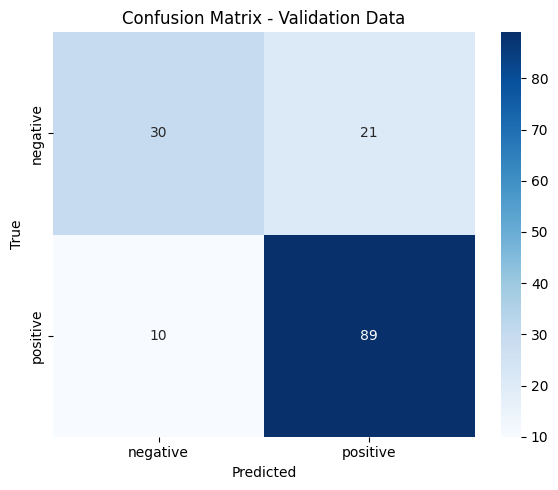


Evaluation on Unseen Test Data:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Unseen Test Metrics: {'eval_loss': 0.5436903834342957, 'eval_accuracy': 0.7976190476190477, 'eval_macro_f1': 0.7812164853684694, 'eval_runtime': 15.2666, 'eval_samples_per_second': 5.502, 'eval_steps_per_second': 0.393, 'epoch': 1.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report (Unseen Test Data):
              precision    recall  f1-score   support

    negative       0.69      0.76      0.72        29
    positive       0.87      0.82      0.84        55

    accuracy                           0.80        84
   macro avg       0.78      0.79      0.78        84
weighted avg       0.80      0.80      0.80        84



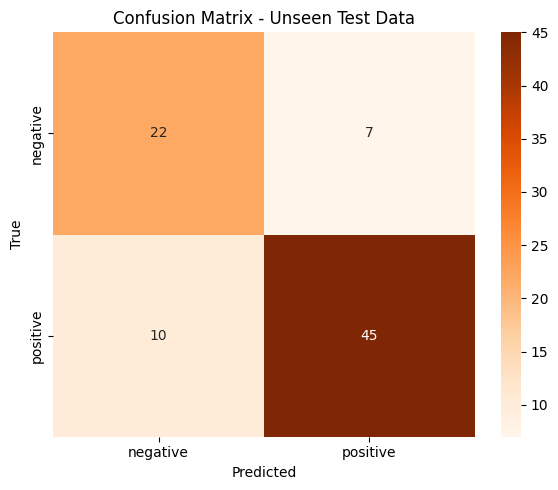

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Validation Evaluation ---
print("\nEvaluation on Validation Data:")
val_metrics = trainer.evaluate(val_dataset)
print("Validation Metrics:", val_metrics)

preds_val = trainer.predict(val_dataset)
y_true_val = preds_val.label_ids
y_pred_val = np.argmax(preds_val.predictions, axis=-1)

print("\nClassification Report (Validation Data):")
print(classification_report(y_true_val, y_pred_val, target_names=label_encoder.classes_))

cm_val = confusion_matrix(y_true_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Data")
plt.tight_layout()
plt.show()

# --- Unseen Test Evaluation ---
print("\nEvaluation on Unseen Test Data:")
unseen_metrics = trainer.evaluate(unseen_dataset)
print("Unseen Test Metrics:", unseen_metrics)

preds_unseen = trainer.predict(unseen_dataset)
y_true_unseen = preds_unseen.label_ids
y_pred_unseen = np.argmax(preds_unseen.predictions, axis=-1)

print("\nClassification Report (Unseen Test Data):")
print(classification_report(y_true_unseen, y_pred_unseen, target_names=label_encoder.classes_))

cm_unseen = confusion_matrix(y_true_unseen, y_pred_unseen)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Oranges",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Unseen Test Data")
plt.tight_layout()
plt.show()
